----------------------------------

# **Time Series with Neural Networks**

----------------------------------

In [2]:
# Imports
# --------------------

import tensorflow as tf, pandas as pd, numpy as np, matplotlib.pyplot as plt

#### **Utilities**

In [3]:
def plot_series(time, series, title, format="-", start=0, end=None):
    """
    Visualizes time series data
    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """    
    plt.figure(figsize=(10, 6))     # Setup dimensions of the graph figure    
    if type(series) is tuple:
      for series_num in series:        
        plt.plot(time[start:end], series_num[start:end], format)    # Plot the time series data
    else:
      plt.plot(time[start:end], series[start:end], format)          # Plot the time series data
    plt.xlabel("Time")          # Label the x-axis    
    plt.ylabel("Value")         # Label the y-axis    
    plt.title(title)
    plt.grid(True)              # Overlay a grid on the graph    
    plt.show()                  # Draw the graph on screen
# =============================================================================================
def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.
    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line
    Returns:
      series (array of float) - measurements that follow a straight line
    """    
    series = slope * time       # Compute the linear series given the slope
    return series
# =============================================================================================
def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish    
    Args:
      season_time (array of float) - contains the measurements per time step
    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """
    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))    
    return data_pattern
# =============================================================================================
def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period
    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values
    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """        
    season_time = ((time + phase) % period) / period            # Define the measured values per period    
    data_pattern = amplitude * seasonal_pattern(season_time)    # Generates the seasonal data scaled by the defined amplitude
    return data_pattern
# =============================================================================================
def noise(time, noise_level=1, seed=None):
    """
    Generates a normally distributed noisy signal
    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability
    Returns:
      noise (array of float) - the noisy signal
    """    
    rnd = np.random.RandomState(seed)       # Initialize the random number generator
    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level    
    return noise
# =============================================================================================

### **Part 1: Preparing time series features and labels**

We will work on preparing time series data into features and labels that we will use to train a model.

Here we will use the **`Windowing technique`**.

`Windowing Technique:` We group consecutive measurement values into one feature and the next measurement will be a label.

Lets say for example - in hourly measurements, we can use values taken at 
- hours 1 to 11 for training
- hour 12 for prediction.

-----------------------------

#### 1.1) - **Creating a Simple Dataset**

In [4]:
# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.range(10)

# Preview the result
for val in dataset:
   print(val.numpy(), end=" ")

0 1 2 3 4 5 6 7 8 9 

#### 1.2) - **Windowing the Data**

We want to group consecutive elements of our data and use that to predict future value.

We will be using the `window()` method for the same.

Here we will take 5 elements per window (`size` parameter), and we will move this window 1 element at a time (`shift` parameter).

```
window(size=5, shift=1) 
```

One caveat (warning) to using this method is that each window returned is a [Dataset](https://www.tensorflow.org/guide/data#dataset_structure) in itself. 

This is a Python iterable and, as of the current version (TF 2.8), it won't show the elements if you use the `print()` method on it. It will just show a description of the data structure (e.g. `<_VariantDataset shapes: (), types: tf.int64>`).

In [5]:
# Generating the dataset [10 elements - numbers 1 to 9]
dataset = tf.data.Dataset.range(10)

# Windowing the data with size = 5 & shift = 1
dataset = dataset.window(size=5, shift=1)

for w in dataset:
    print(w)

<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


In [6]:
# To see the elements, we will have to iterate over each iterable. 
# We can do this by modifying print statement with either a 
#   > nested for loop
#   > list comprehension
# 
for w in dataset:
    print([item.numpy() for item in w])


[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]
[6, 7, 8, 9]
[7, 8, 9]
[8, 9]
[9]


In [7]:
# Now that we see the elements of each window, 
#  we can notice that the resulting sets are not sized evenly 
#  because there are no more elements after the number `9`. 
# 
# We will use the `drop_remainder` flag to make sure that 
#  only 5-element windows are retained.
# 
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(size=5, shift=1, drop_remainder=True)
for w in dataset:
    print([i.numpy() for i in w])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


#### 1.3) - **Flattening the Window**

For training the model later, we will prepare the windows to be `tensors` instead of `Dataset structure`.

We can do this by feeding a mapping function to the `flap_map()` method. We can apply this function to each window and results will be ***flattened into a single dataset***.

In [8]:
# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda w: w.batch(5))
for w in dataset: 
    print(w.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


#### 1.4) - **Grouping into features and labels**

We will mark the labels in each window.


In [9]:
# For our problem, we will be splitting the 
#       last element for each windown from first 4.

dataset = tf.data.Dataset.range(10)
dataset = dataset.window(size=5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda w: w.batch(5))
dataset = dataset.map(lambda w: (w[:-1], w[-1]))

for x,y in dataset:     # Print the results
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()

x =  [0 1 2 3]
y =  4

x =  [1 2 3 4]
y =  5

x =  [2 3 4 5]
y =  6

x =  [3 4 5 6]
y =  7

x =  [4 5 6 7]
y =  8

x =  [5 6 7 8]
y =  9



#### 1.5) - **Shuffling the Data**

**`Good Practice`**<br>
We will shuffle the dataset to reduce *sequence bias* while training your model. This refers to the neural network overfitting to the order of inputs and consequently, it will not perform well when it does not see that particular order when testing. we don't want the sequence of training inputs to impact the network this way so it's good to shuffle them up. 

We will use the [shuffle()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) method to do this. The `buffer_size` parameter is required for that and as mentioned in the doc, you should put a number equal or greater than the total number of elements for better shuffling. We can see from the previous cells that the total number of windows in the dataset is `6` so we can choose this number or higher.

In [10]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(size=5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda w: w.batch(5))
dataset = dataset.map(lambda w: (w[:-1], w[-1]))
dataset = dataset.shuffle(buffer_size=10)

for x,y in dataset:     # Print the results
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()

x =  [3 4 5 6]
y =  7

x =  [1 2 3 4]
y =  5

x =  [4 5 6 7]
y =  8

x =  [0 1 2 3]
y =  4

x =  [5 6 7 8]
y =  9

x =  [2 3 4 5]
y =  6



#### 1.6) - **Creating batches for training**

Last step here will be to group the windows into batches.

We can do that with the [batch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) method as shown below. Simply specify the batch size and it will return a batched dataset with that number of windows. 

As a rule of thumb, it is also good to specify a [prefetch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) step. This optimizes the execution time when the model is already training. By specifying a prefetch `buffer_size` of `1` as shown below, Tensorflow will prepare the next one batch in advance (i.e. putting it in a buffer) while the current batch is being consumed by the model. 

More information about it can be found here: [here](https://towardsdatascience.com/optimising-your-input-pipeline-performance-with-tf-data-part-1-32e52a30cac4#Prefetching).


In [11]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(size=5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda w: w.batch(5))
dataset = dataset.map(lambda w: (w[:-1], w[-1]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)

for x,y in dataset:     # Print the results
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()

x =  [[4 5 6 7]
 [0 1 2 3]]
y =  [8 4]

x =  [[2 3 4 5]
 [3 4 5 6]]
y =  [6 7]

x =  [[5 6 7 8]
 [1 2 3 4]]
y =  [9 5]



-----------------------------------------

### **Part 2: Training a Single Layer Neural Network with Time Series Data**

Learnings for this task:

* Build a single layer network and train it using the same synthetic data we generated above.
* Prepare time series data for training and evaluation.
* Measure the performance of the model against a validation set.

#### 2.1) - **Generate the Synthetic Data**

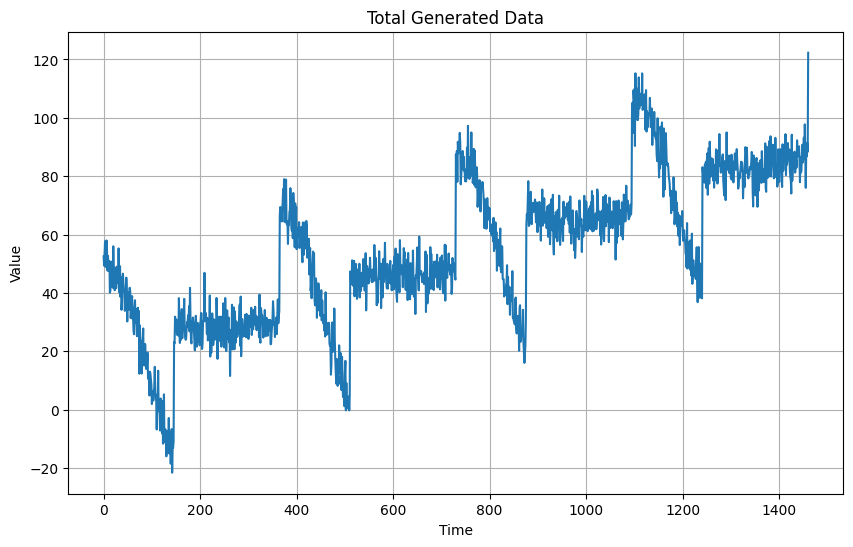

In [12]:
# Defining the Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Creating the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series, title="Total Generated Data")

#### 2.2) - **Splitting the Dataset**

- Splitting the Data into Training and Validation
- We will take first 1,000 points for training and the rest for validation


In [13]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

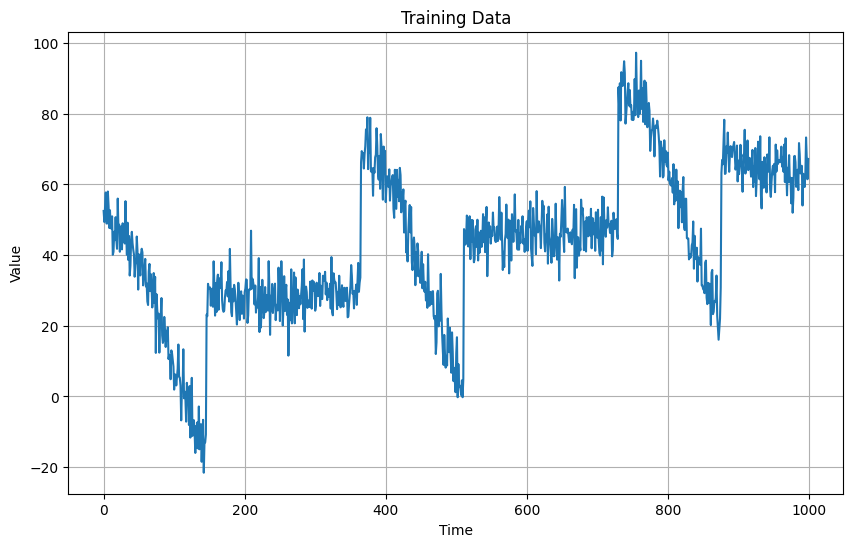

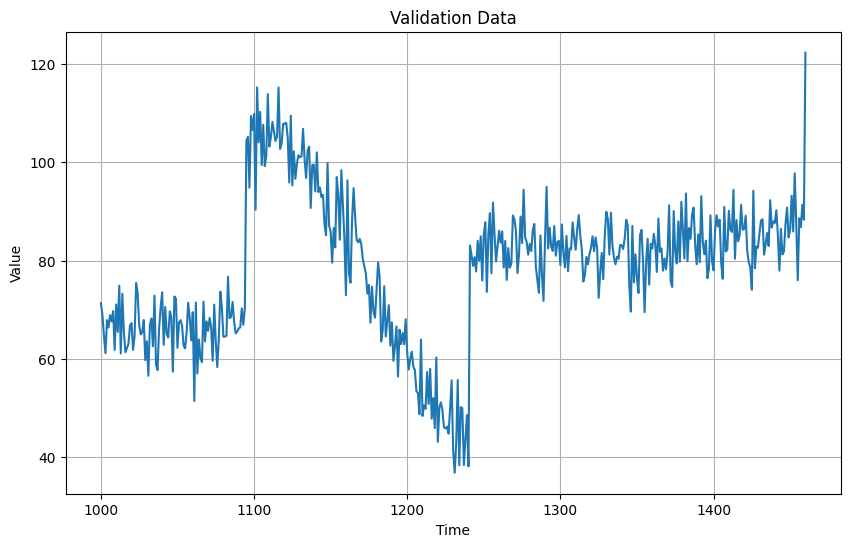

In [14]:
# ---------------------------------------------------------------
# Visualizing the datsets
# ---------------------------------------------------------------
plot_series(time_train, x_train, title="Training Data")          # Plot the train set
plot_series(time_valid, x_valid, title="Validation Data")        # Plot the validation set

#### 2.3) - **Prepare features and labels**

- Preparing data windows.
- Defining the Parameters

The following function contains all the preprocessing that we did in the previous part of th code. 

This makes it modular so it can be easily used. 

One thing to note here is the `window_size + 1` when you call `dataset.window()`. There is a `+ 1` to indicate that you're taking the next point as the label. 

For example, the first 20 points will be the feature so the 21st point will be the label.


In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Generates dataset windows
    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method
    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """  
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)   
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [16]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#### 2.4) - **Inspecting the Data**

We can again inspect the output generated above to check if everything is working as expected.

We can use the `take()` method from `tf.data.Dataset` API to grab a single batch.

It will then print several properties of this batch such as the data type and shape of the elements. As expected, it should have a 2-element tuple (i.e. `(feature, label)`) and the shapes of these should align with the batch and window sizes you declared earlier which are `32` and `20` by default, respectively.

In [17]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type:                        {type(windows)}')
  print(f'number of elements in the tuple:  {len(windows)}')
  print(f'shape of first element:           {windows[0].shape}')
  print(f'shape of second element:          {windows[1].shape}')

data type:                        <class 'tuple'>
number of elements in the tuple:  2
shape of first element:           (32, 20)
shape of second element:          (32,)


#### 2.5) - **Building and Compiling the Model**

- Single Layer Neural Network.
- 1-unit Dense Layer
- `Error/Loss Function` ==> Mean Squared Error [MSE]
- `Optimizer` ==> Stochastic Gradient Descent (SGD)

In [18]:
# Build the single layer neural network
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

# Print the initial layer weights
print("Layer weights: \n {} \n".format(l0.get_weights()))

# Print the model summary
model.summary()

Layer weights: 
 [array([[-0.46955505],
       [ 0.4745744 ],
       [ 0.07124603],
       [-0.05986232],
       [ 0.46993965],
       [ 0.10332245],
       [-0.03111005],
       [-0.32177794],
       [-0.15105703],
       [-0.3411004 ],
       [-0.39222312],
       [ 0.28841645],
       [-0.34814784],
       [ 0.20656723],
       [ 0.5210245 ],
       [-0.16238403],
       [-0.05495587],
       [-0.26406363],
       [-0.03869337],
       [ 0.2827624 ]], dtype=float32), array([0.], dtype=float32)] 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Set the training parameters
model.compile(loss="mse", 
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

#### 2.6) - **Training the Model**

- Epochs = 100

In [20]:
model.fit(dataset, epochs=100)      # Training the Model

Epoch 1/100
31/31 [==============================] - 3s 15ms/step - loss: 723.5199
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 146.4196
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 109.3653
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 100.1955
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 93.9916
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 91.6590
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 88.1827
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 85.1070
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 83.9116
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 81.3658
Epoch 11/100
31/31 [==============================] - 0s 4ms/step - loss: 80.5749
Epoch 12/100
31/31 [==============================] - 0s 4ms/step - loss: 77.6145
Epoch 13/100
31/31 [

In [21]:
# Printing the Layer Weights -" get_weights()"
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.11332397],
       [ 0.07874938],
       [ 0.02621399],
       [-0.05080607],
       [ 0.07656472],
       [ 0.02479495],
       [-0.01641936],
       [-0.02175427],
       [-0.00845672],
       [ 0.00600767],
       [-0.04180919],
       [ 0.06691238],
       [-0.10765689],
       [ 0.06130597],
       [ 0.09941673],
       [ 0.02475982],
       [ 0.02153754],
       [ 0.11917926],
       [ 0.27045962],
       [ 0.4763767 ]], dtype=float32), array([0.01563911], dtype=float32)]


#### 2.7) - **Prediction from the Model**

We can generate a model prediction by passing a batch of data windows. 

If we slice a window from the original series array, we will need to add a batch dimension before passing it to the model.

This can be done with [`np.newaxis`](https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis#numpy.newaxis) constant or using the [`np.expand_dims()`](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) method.

In [22]:
# Shape of the first 20 data points slice
print(f'shape of series[0:20]:                  {series[0:20].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][np.newaxis]:      {series[0:20][np.newaxis].shape}')

# Shape after adding a batch dimension (alternate way)
print(f'shape of series[0:20][np.newaxis]:      {np.expand_dims(series[0:20], axis=0).shape}')

# Sample model prediction
print(f'model prediction:                       {model.predict(series[0:20][np.newaxis])}')

shape of series[0:20]:                  (20,)
shape of series[0:20][np.newaxis]:      (1, 20)
shape of series[0:20][np.newaxis]:      (1, 20)
1/1 [==============================] - 0s 82ms/step
model prediction:                       [[41.469242]]


To compute a performance metric, we will need to generate model predictions for our validation set. This is the set of points at index `1000 to 1460` of the entire series. 

Basically it feeds the entire series to the model 20 points at a time and append all results to a forecast list. It will then slice the points that corresponds to the validation set.

The slice index below is `split_time - window_size:` because the forecast list is smaller than the series by 20 points (i.e. the window size). Since the window size is 20, the first data point in the `forecast` list corresponds to the prediction for time at index `20`. You cannot make predictions at index `0` to `19` because those are smaller than the window size. Thus, when you slice with `split_time - window_size:`, you will be getting the points at the time indices that aligns with those in the validation set.

*Note: We might notice that this cell takes a while to run.*

In [23]:
# Initialize a list
forecast = []

# Use the model to predict data points per window size
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Slice the points that are aligned with the validation set
forecast = forecast[split_time - window_size:]

# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

1/1 [==============================] - 0s 26ms/step
length of the forecast list: 461
shape of the validation set: (461,)


shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


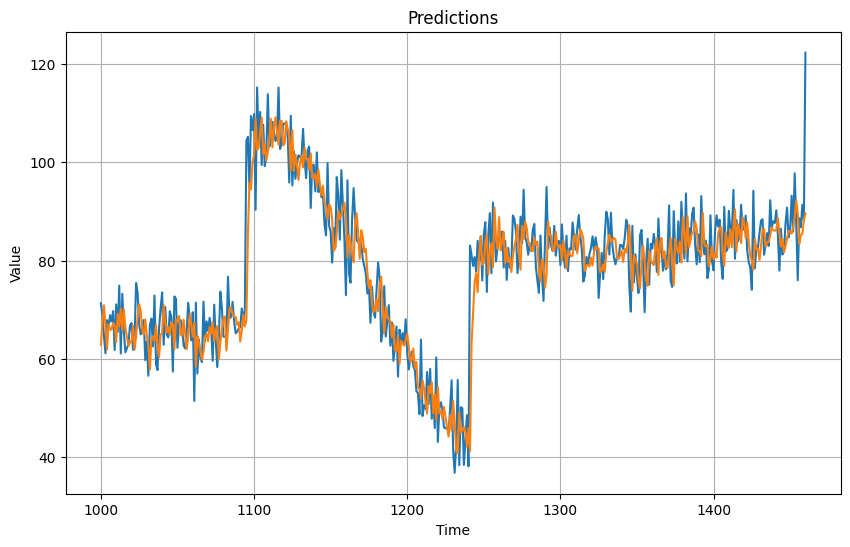

In [24]:
# Visualizing the Results
# ----------------------------------

# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(time_valid, (x_valid, results), title="Predictions")

In [25]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

47.09066
5.1037807


---------------------------------------

### **Part 3: Training a Deep Neural Network with Time Series Data**

- We will build upon the above code and add more dense layers to our network. 

- We will also look at a technique to tune the model's learning rate to make the weights converge faster. This is a useful tip so we can avoid guessing the learning rate before training.


#### 3.1) - **Generating the Synthetic Data + Splitting the Data**

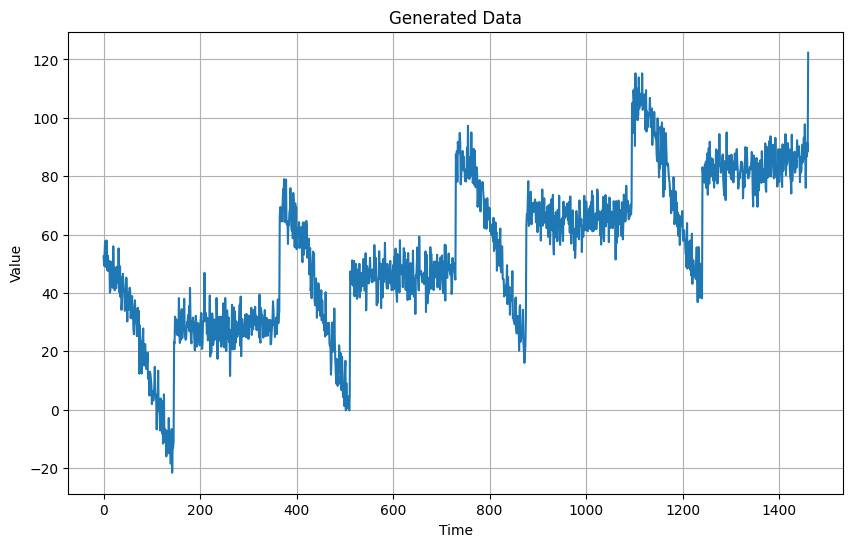

In [28]:
# -------------------------------
# Gnerating the Data
# -------------------------------
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series, title="Generated Data")

# -------------------------------
# Split the Data
# -------------------------------
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

#### 3.2) - **Prepare Features and Labels**

In [29]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [30]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#### 3.3) - **Building the Model**

In [31]:
# Build the model
# --->>> 3 dense layers
# 
# 
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# Print the model summary
model_baseline.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Set the training parameters
model_baseline.compile(loss="mse", 
                       optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, 
                                                         momentum=0.9))

#### 3.4) - **Training the Model**

In [33]:
model_baseline.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 10ms/step - loss: 620.0446
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 125.9915
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 104.6607
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 97.2759
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 91.1696
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 88.1343
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 85.0000
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 82.0023
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 79.5880
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 77.6540
Epoch 11/100
31/31 [==============================] - 0s 4ms/step - loss: 76.7791
Epoch 12/100
31/31 [==============================] - 0s 4ms/step - loss: 75.4262
Epoch 13/100
31/31 [=

#### 3.5) - **Making the Predictions**

We can get some predictions and visualize it as we did before. But here since the network is deeper, the predictinos might go slower.

We want minimize unnecessary computations.

In the code for Single layer Neural Network above, what we did was:
1. Predicted on the entire series data.
2. Sliced out the validation set later.

Now what we will do is:
1. We will slice the validation set beforehand.
2. Forecast only for the validation set.

1/1 [==============================] - 0s 25ms/step


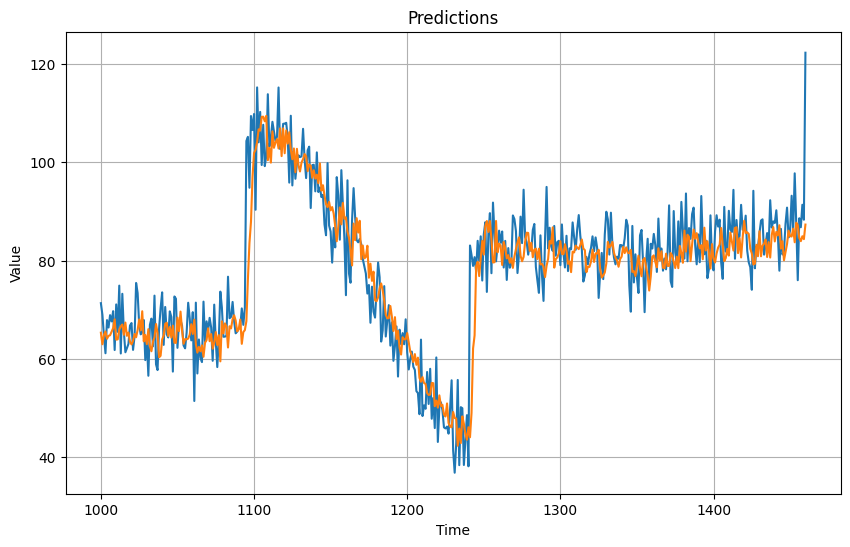

In [34]:
forecast = []           # Initialize a list
forecast_series = series[split_time - window_size:]     # Reduce the original series

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_baseline.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results), title="Predictions")

In [35]:
# Compute the metrics
print("Mean Squared Error: ",tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print("Mean Absolute Error: ",tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

Mean Squared Error:  48.409836
Mean Absolute Error:  5.062797


#### 3.6) - **Tuning the Learning Rate**

We see that training went well with learning rate (1e-6). But there might be a better learning rate that will generate a better prediction for this particular model.

It might seem inconsequential in this simple model but when we have a more complex model, spending some time to tune the learning rate can lead to better training results.

We will be using a **`Learning Rate Scheduler callback`**. This will allow to dynamically set learning rate based on the number of epochs during training.

We 


**Steps to tune the learning rate**:

1. Build the same model architecture as we used above.

2. Declare a `learning rate scheduler callback`. We will pass a lambda function to declare the value of the learning rate. It will start at `1e-8` at epoch 0 and is scaled by `10**(epoch / 20)` as the training goes on.

3. We will then compile the model. Here we will not use the `learning_rate` argument for the optimizer function, and rather keep it default (`0.01` for SGD). The learning_rate_scheduler will set it dynamically.

4. Training the Model. Here we will pass the `lr_schedule callback` in `callbacks` parameter in the `fit()` method. We will notice the learning rate at a particular epoch denoted by `lr` in the console output. We will notice that it is increasing as expected based on the lambda function we used.

In [36]:
# 1. Building the same model architecture as we used above
# --------------------------------------------------------
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# 2. Declare a `learning rate scheduler callback`
# -----------------------------------------------
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))


# 3. Compiling the Model
# ----------------------
optimizer = tf.keras.optimizers.SGD(momentum=0.9)       # Initialize the optimizer
model_tune.compile(loss="mse", optimizer=optimizer)     # Set the training parameters

# 4. Training the Model
# ---------------------
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 13ms/step - loss: 2256.7690 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 1128.5139 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 529.5840 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 284.3110 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 197.8020 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 168.5565 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 159.7944 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 156.8503 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 155.3609 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 154.0512 - lr: 2.8184e-08
Epoch 

#### 3.6) - **Plotting training results after tuning learning rate**

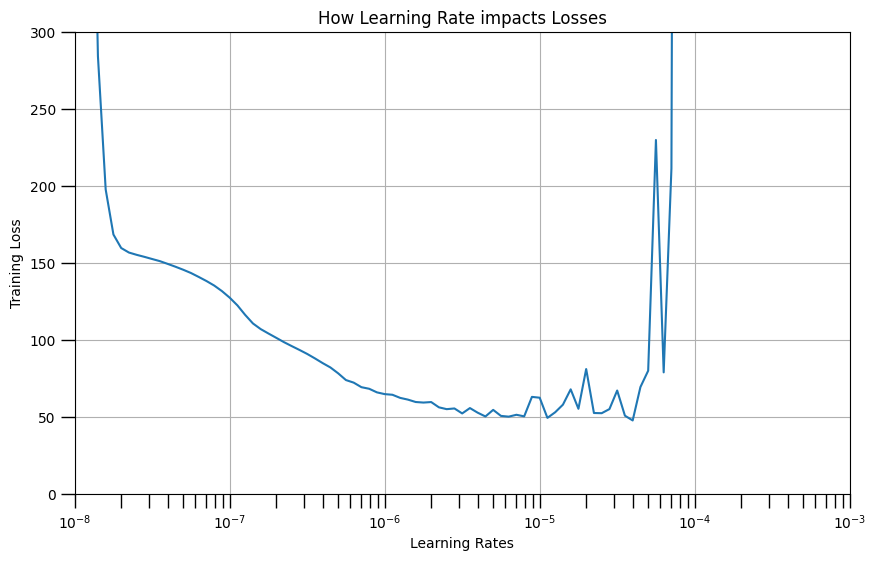

In [38]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))      # Define the learning rate array
plt.figure(figsize=(10, 6))                     # Set the figure size
plt.grid(True)                                  # Set the grid
plt.semilogx(lrs, history.history["loss"])      # Plot the loss in log scale
plt.tick_params('both', length=10, width=1, which='both')   # Increase the tickmarks size
plt.axis([1e-8, 1e-3, 0, 300])                  # Set the plot boundaries
plt.xlabel('Learning Rates')
plt.ylabel('Training Loss')
plt.title("How Learning Rate impacts Losses")
plt.show()

In [ ]:
# Observations from the Graph
# ---------------------------
